# Gesture Recognition
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.



<br>
<br>



# 1. Importing Libs

In [143]:
import numpy as np
import os
import imageio
import datetime
import os
import cv2
import matplotlib.pyplot as plt
import random
import seaborn as sns
from skimage import transform
from  skimage.transform import resize
import warnings
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Conv2D, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras import optimizers
from tensorflow.keras.applications.resnet import ResNet50
from keras.models import load_model

In [2]:
warnings.filterwarnings('ignore')

In [3]:
!nvidia-smi

Wed Oct 27 12:26:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.compat.v1.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

drive.flush_and_unmount()

In [6]:
directory =os.getcwd().replace("\\" , "/")
print(directory)

/content


In [7]:
IsColab = True
try :
  from google.colab import drive
except:
  IsColab = False
  pass

if IsColab:
  directory += '/drive/MyDrive/Deep Learning/RNN/Assignments'
  print(directory)

/content/drive/MyDrive/Deep Learning/RNN/Assignments


In [9]:
train_doc = np.random.permutation(open(directory + '/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(directory + '/Project_data/Project_data/val.csv').readlines())



batch_size = 64 #batch_size_lst[2] #experiment with the batch size


In [10]:
train_doc[:5], val_doc[:5]

(array(['WIN_20180907_16_38_29_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n',
        'WIN_20180926_17_15_56_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
        'WIN_20180926_17_33_51_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
        'WIN_20180907_15_43_28_Pro_Right Swipe_new;Right Swipe_new;1\n',
        'WIN_20180926_16_49_49_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'],
       dtype='<U88'),
 array(['WIN_20180926_17_40_21_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
        'WIN_20180907_16_36_42_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n',
        'WIN_20180926_16_52_49_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
        'WIN_20180907_16_18_23_Pro_Thumbs Down_new;Thumbs Down_new;3\n',
        'WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_Swipe_new;0\n'],
       dtype='<U88'))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [47]:
def ScaleNormalizeImage(Image, TargetSize : tuple, NormFactor : int = 255, Type : str = 'MinMax'):  
  
    _Image = cv2.resize(Image, TargetSize)
    if Type =="MinMax":
        return (_Image - np.min(_Image))/(np.max(_Image) - np.min(_Image))
    elif Type =="ConstantScale":
        return _Image/NormFactor

In [46]:
def ImagePreProcessing(folder_list,source_path, batch_size, batch,img_idx, IsAugmentation, shear_angles  : list = [] ):
  batch_data = np.zeros((batch_size,20,90,90,3), dtype = np.float) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((batch_size,5), dtype = np.uint) # batch_labels is the one hot representation of the output
  for folder in range(batch_size): # iterate over the batch_size
              
      folder_dir_path = source_path +'/'+ folder_list[folder + (batch*batch_size)].split(';')[0]
      imgs = os.listdir(folder_dir_path) 
     
        
      for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
        image = cv2.imread(folder_dir_path +'/'+imgs[item])

        if IsAugmentation:
          if bool(random.randint(0,1)):
            shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
            matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
            matrix_to_center = transform.SimilarityTransform(translation=[shift_x, shift_y])
           
            shear_transforms = transform.AffineTransform(shear=np.deg2rad(shear_angles[random.randint(0,len(shear_angles)-1)]))
            shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
            image = transform.warp(image, shear_matrix)

        batch_data[folder,idx,:,:,0],  batch_data[folder,idx,:,:,1], batch_data[folder,idx,:,:,2] = [ScaleNormalizeImage(image[:,:,i], (90,90), 255, 'MinMax' ) for i in range(3)]
                    
                           
      batch_labels[folder, int(folder_list[folder + (batch*batch_size)].strip().split(';')[2])] = 1
  return batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do"""

In [52]:
def generator(source_path, folder_list, batch_size, IsAugmentation, ShearAngles : list = []):
    """Custom Generator function to load  sampled images and  preprocess them to feed to model

    Args:
        source_path (string): [Root directory where dataset is present]
        folder_list (array): [List of all the folders of images]
        batch_size (int): [Its the number of batch size that need to be feed]

    Yields:
        [type]: [object for data of batch dataset and respective labels]
    """
    print( 'Source path = ', source_path, '; batch size = ', batch_size)
    img_idx = [0, 1, 15, 26, 9, 14, 5, 11, 19, 21, 28, 8, 10, 17, 25, 3, 12, 2, 23, 19 ] #create a list of image numbers you want to use for a particular video

    #base = np.random.randint(10)
    #img_idx = [base + i for i in range(20)] #create a list of image numbers you want to use for a particular video
  
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        rem_batch_size = len(t)%batch_size - 1

     
        for batch in range(num_batches + 1): # we iterate over the number of batches
          if  batch < num_batches:
            _data_stream = ImagePreProcessing( t,source_path, batch_size, batch, img_idx, IsAugmentation,ShearAngles)
            yield _data_stream

          else:
            _data_stream = ImagePreProcessing( t, source_path, rem_batch_size, batch, img_idx,IsAugmentation,ShearAngles)
            yield _data_stream

#### Test logic

(360, 360, 3)


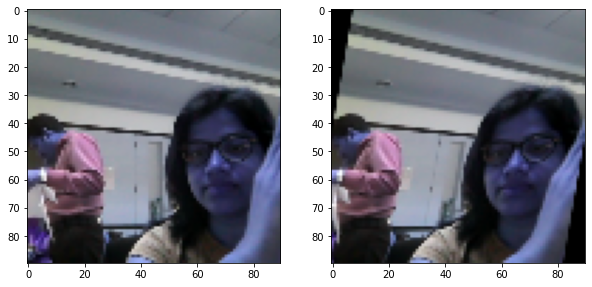

In [43]:
from skimage import exposure

plt.figure(figsize= [10,10])


image = cv2.imread('/content/drive/MyDrive/Deep Learning/RNN/Assignments/Project_data/Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png').astype(np.uint16)



plt.subplot(1,2,1)
plt.imshow(ScaleNormalizeImage( image,(90,90), 255 ,'MinMax' ), cmap= 'gray')
print(image.shape)

plt.subplot(1,2,2)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
matrix_to_topleft = transform.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = transform.SimilarityTransform(translation=[shift_x, shift_y])
shear_transforms = transform.AffineTransform(shear=np.deg2rad(np.random.randint(low = -10,high = 10)))
shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
image = transform.warp(image, shear_matrix)
plt.imshow(ScaleNormalizeImage( image,(90,90), 255 ,'MinMax' ), cmap= 'gray')



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [49]:
curr_dt_time = datetime.datetime.now()
train_path = directory + '/Project_data/Project_data/train'
val_path = directory + '/Project_data/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


# CNN + RNN(GRU)


  **Using a transfer learning technique we are using pre-trained model of ResNet50 and extracting features from it and then flatenning it, then we repeat this for whole 20 frames using the time distributed layer and then give output to  GRU layers which hereby take the sequential data and then process to feed a dense layer which thereby classifies the frames.**

## Model build experiment - 1

In [16]:
def GenerateModel_1():
  
  #CNN Stack with pre-trained model of ResNet50
  resnet = ResNet50(include_top= False, weights= 'imagenet', input_shape= (90,90,3))

  for layer in resnet.layers:
      layer.trainable = False


  # CNN Model
  CNN_Model = Sequential([resnet])


  # CNN Model - Global pooling & Dropout
  CNN_Model.add(GlobalMaxPooling2D())
  CNN_Model.add(Dropout(0.3))

  # Flatten layer
  CNN_Model.add(Flatten())

  #RNN -> GRU Stack

  GRU_Model = Sequential()

  # Time distributed layer
  GRU_Model.add(TimeDistributed(CNN_Model,input_shape=(20,90,90,3)))

  # GRU layer 1
  GRU_Model.add(GRU(64,return_sequences=True))

  # GRU layer 2
  GRU_Model.add(GRU(32))

  GRU_Model.add(Dropout(0.25))

  GRU_Model.add(Dense(32,activation='relu'))

  GRU_Model.add(Dropout(0.25))

  # Output layer
  GRU_Model.add(Dense(5,activation='softmax', name = 'fcnew'))

  return GRU_Model

Now that we have written the model, the next step is to `compile` the model. When you print the `summary` of the model, we'll see the total number of parameters you have to train.

In [15]:
def CompileModel(Model, Optimiser):
  Model.compile(optimizer=Optimiser, 
                    loss=tf.losses.categorical_crossentropy, 
                    metrics=['categorical_accuracy'])
  return Model

In [18]:
Model1 = CompileModel(GenerateModel_1(), 'Adam')
Model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 2048)          23587712  
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 64)            405888    
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
fcnew (Dense)                (None, 5)                

Let us create the `train_generator` and the `val_generator` which will be used in `.fit`.

In [30]:
train_generator = generator(train_path, train_doc, batch_size, True, [-10, -5, 5, 10]  ) # with shear augmentation angles
val_generator = generator(val_path, val_doc, batch_size, False)

In [16]:
def GenerateModelPath(directory):
  model_path = directory + '/' + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
      
  if not os.path.exists(model_path):
      os.mkdir(model_path)

  model_name = 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'   
      
  filepath = model_path + model_name

  return model_path, filepath

### Callbacks

In [32]:
ModelPath, FilePath = GenerateModelPath(directory)

checkpoint = ModelCheckpoint(filepath= FilePath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto')

LR =  ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=10, 
                        min_lr=0.00001,
                        verbrose = 1)

ES = EarlyStopping(monitor='val_loss', 
                  min_delta=0.001, 
                  patience=20, 
                  verbose=1,
                  mode='auto')

In [33]:
CSVLogPath = ModelPath + 'TrainLog.csv'

CSVLog = CSVLogger(filename = CSVLogPath, 
                   separator=",", 
                   append=False)

In [34]:
callbacks_list = [ES,LR, CSVLog, checkpoint]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [36]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, we'll be able to save the model as per the checkpoint configuration.

In [39]:
Model1.fit(train_generator, 
              steps_per_epoch=steps_per_epoch, 
              epochs=num_epochs, 
              verbose=1,  
              callbacks=callbacks_list, 
              validation_data=val_generator,  
              validation_steps=validation_steps, 
              class_weight=None, 
              workers=1, 
              initial_epoch=0)

Source path =  /content/drive/MyDrive/Deep Learning/RNN/Assignments/Project_data/Project_data/train ; batch size =  64
Epoch 1/30
11/11 [==============================] - 8018s 801s/step - loss: 1.6511 - categorical_accuracy: 0.2190 - val_loss: 1.6060 - val_categorical_accuracy: 0.2121

Epoch 00001: val_loss improved from inf to 1.60600, saving model to /content/drive/MyDrive/Deep Learning/RNN/Assignments/model_init_2021-10-2706_14_18.214318/model-00001-1.65110-0.21903-1.60600-0.21212.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
11/11 [==============================] - 541s 54s/step - loss: 1.6101 - categorical_accuracy: 0.2311 - val_loss: 1.5711 - val_categorical_accuracy: 0.3737

Epoch 00002: val_loss improved from 1.60600 to 1.57112, saving model to /content/drive/MyDrive/Deep Learning/RNN/Assignments/model_init_2021-10-2706_14_18.214318/model-00002-1.61009-0.23112-1.57112-0.37374.h5
Epoch 3/30
11/11 [==============================] - 137s 14s/step - loss: 1.5795 - categorical_accuracy: 0.2477 - val_loss: 1.5266 - val_categorical_accuracy: 0.2121

Epoch 00003: val_loss improved from 1.57112 to 1.52656, saving model to /content/drive/MyDrive/Deep Learning/RNN/Assignments/model_init_2021-10-2706_14_18.214318/model-00003-1.57953-0.24773-1.52656-0.21212.h5
Epoch 4/30
11/11 [==============================] - 108s 11s/step - loss: 1.5500 - categorical_accuracy: 0.2779 - val_loss: 1.4810 - val_categorical_accuracy: 0.3636

Epoch 00004: val_loss improved from 1.52656 to 1.48100, saving model to /content/

In [39]:
def GetModelPerformances(history,epochs, info):
    """[Evaluates a model performance]

    Args:
        history ([model.history]): [Model history on which evaluation, is to be done]
    """
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)

    plt.figure(figsize=(20, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc,linestyle = 'dashed' , label='Validation Accuracy')
    plt.axhline(y = 0.2, color ='r' ,linestyle = 'dotted',label = 'Base Accuracy for 5 classes')
    plt.legend(loc='upper left')
    plt.title('Train and Val Accuracy - ' + info) 

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss,linestyle = '-', label='Training Loss')
    plt.plot(epochs_range, val_loss,linestyle = 'dashed', label='Validation Loss')
    plt.legend(loc='upper left')
    plt.title('Train and Val Loss - ' + info )
    plt.show()

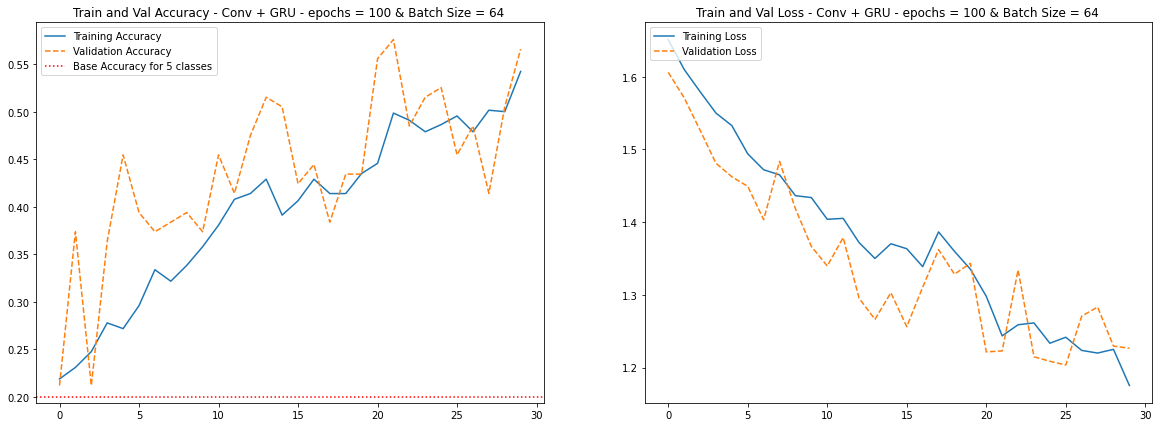

In [43]:
GetModelPerformances(history = Model1.history,
                     epochs = num_epochs, 
                     info = "Conv + GRU - epochs = 100 & Batch Size = 64 ")

**Conclusion for Model - 1**

  ○ Model is not overfitting but the accuracy is less.

  ○ Increase the batchsize to 128 and epochs to 50.

  ○ Try with more augmentation angles.

  ○ Let's save the best model for all epochs for next run.






## Model build experiment - 2

In [44]:
Model2 = CompileModel(GenerateModel_1(), 'Adam')
Model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 20, 2048)          23587712  
_________________________________________________________________
gru_4 (GRU)                  (None, 20, 64)            405888    
_________________________________________________________________
gru_5 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
fcnew (Dense)                (None, 5)                

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [46]:
num_epochs = 50
batch_size = 128

In [47]:
train_generator = generator(train_path, train_doc, batch_size, True, [-15, -10, -5, 5, 10, 15]  )
val_generator = generator(val_path, val_doc, batch_size, False)

In [48]:
def GenerateModelPath(directory):
  model_path = directory + '/' + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
      
  if not os.path.exists(model_path):
      os.mkdir(model_path)

  model_name = 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'   
      
  filepath = model_path + model_name

  return model_path, filepath

### Callbacks

In [49]:
ModelPath, FilePath = GenerateModelPath(directory)

checkpoint = ModelCheckpoint(filepath= FilePath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto')

LR =  ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=10, 
                        min_lr=0.00001,
                        verbrose = 1)

ES = EarlyStopping(monitor='val_loss', 
                  min_delta=0.001, 
                  patience=20, 
                  verbose=1,
                  mode='auto')

In [50]:
CSVLogPath = ModelPath + 'TrainLog.csv'

CSVLog = CSVLogger(filename = CSVLogPath, 
                   separator=",", 
                   append=False)

In [51]:
callbacks_list = [ES,LR, CSVLog, checkpoint]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [52]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [53]:
Model2.fit(train_generator, 
              steps_per_epoch=steps_per_epoch, 
              epochs=num_epochs, 
              verbose=1,  
              callbacks=callbacks_list, 
              validation_data=val_generator,  
              validation_steps=validation_steps, 
              class_weight=None, 
              workers=1,  
              initial_epoch=0)

Source path =  /content/drive/MyDrive/Deep Learning/RNN/Assignments/Project_data/Project_data/train ; batch size =  128
Epoch 1/50
6/6 [==============================] - 965s 191s/step - loss: 1.7035 - categorical_accuracy: 0.2160 - val_loss: 1.6202 - val_categorical_accuracy: 0.2525

Epoch 00001: val_loss improved from inf to 1.62015, saving model to /content/drive/MyDrive/Deep Learning/RNN/Assignments/model_init_2021-10-2706_14_50.518855/model-00001-1.70347-0.21601-1.62015-0.25253.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
6/6 [==============================] - 143s 28s/step - loss: 1.6282 - categorical_accuracy: 0.2402 - val_loss: 1.6086 - val_categorical_accuracy: 0.2020

Epoch 00002: val_loss improved from 1.62015 to 1.60859, saving model to /content/drive/MyDrive/Deep Learning/RNN/Assignments/model_init_2021-10-2706_14_50.518855/model-00002-1.62819-0.24018-1.60859-0.20202.h5
Epoch 3/50
6/6 [==============================] - 112s 22s/step - loss: 1.6323 - categorical_accuracy: 0.2054 - val_loss: 1.6003 - val_categorical_accuracy: 0.2525

Epoch 00003: val_loss improved from 1.60859 to 1.60029, saving model to /content/drive/MyDrive/Deep Learning/RNN/Assignments/model_init_2021-10-2706_14_50.518855/model-00003-1.63232-0.20544-1.60029-0.25253.h5
Epoch 4/50
6/6 [==============================] - 107s 21s/step - loss: 1.6039 - categorical_accuracy: 0.2538 - val_loss: 1.5730 - val_categorical_accuracy: 0.3636

Epoch 00004: val_loss improved from 1.60029 to 1.57299, saving model to /content/drive/

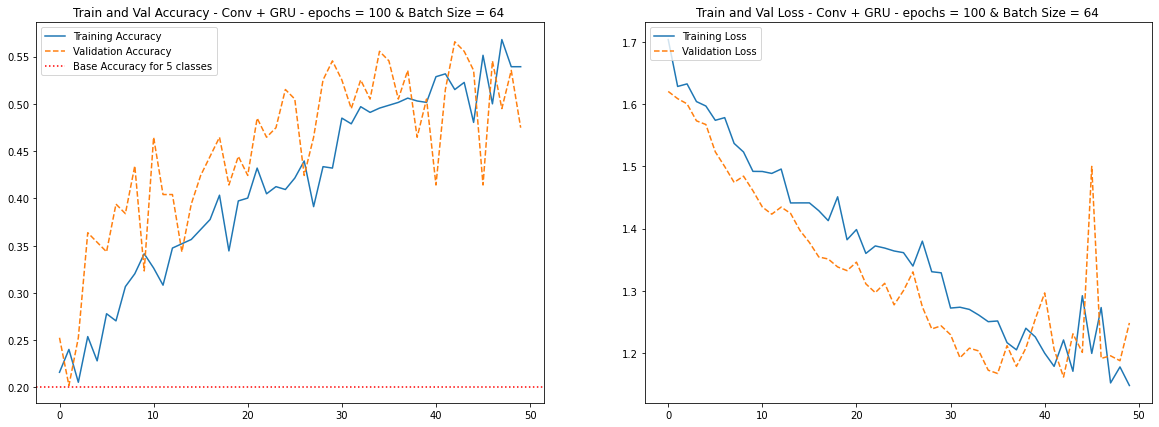

In [54]:
GetModelPerformances(history = Model2.history,
                     epochs = num_epochs, 
                     info = "Conv + GRU - epochs = 50 & Batch Size = 128 ")

**Conclusion**

  ○ Increasing batch size and epoch didn't help much.
  
  ○ Seems like model and validation accuracy are saturating, so we need more layers to capure more patterns in the data.

  ○ $ResNet50$ is quite bulky if we try to train the network as a whole and beyond capability of our GPU+CPU.

  ○ We, will use a different lite pre-trained model of $MobileNet$.

## Model build experiment - 3

*Using MobileNet*


In [77]:
from keras.applications import mobilenet

def GenerateModel_2():
  
  _mobilenet = mobilenet.MobileNet(include_top= False, weights= 'imagenet', input_shape= (90,90,3))


  # CNN Model
  CNN_Model = Sequential([_mobilenet])


  # CNN Model - Global pooling & Dropout
  CNN_Model.add(MaxPooling2D(2,2))
  CNN_Model.add(Dropout(0.1))

  # Flatten layer
  CNN_Model.add(Flatten())

  #RNN -> GRU Stack

  GRU_Model = Sequential()

  # Time distributed layer
  GRU_Model.add(TimeDistributed(CNN_Model,input_shape=(20,90,90,3)))

  # GRU layer 1
  GRU_Model.add(GRU(128))

  GRU_Model.add(Dropout(0.25))

  GRU_Model.add(Dense(128,activation='relu'))

  GRU_Model.add(Dropout(0.25))

  # Output layer
  GRU_Model.add(Dense(5,activation='softmax', name = 'fcnew'))

  return GRU_Model 



In [78]:
Model3 = CompileModel(GenerateModel_2(), 'Adam')
Model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 20, 1024)          3228864   
_________________________________________________________________
gru_6 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
fcnew (Dense)                (None, 5)                 645       
Total params: 3,689,157
Trainable params: 3,667,269
Non-trainable params: 21,888
_______________________________________

**As we can see there are parameters of the Mobilenet coming in the model summary**

In [88]:
"""batch_size = 128"""

In [89]:
"""train_generator = generator(train_path, train_doc, batch_size, True, [-15, -10, -5, 5, 10, 15] )
val_generator = generator(val_path, val_doc, batch_size, False)"""

In [90]:
"""ModelPath, FilePath = GenerateModelPath(directory)

CSVLogPath = ModelPath + 'TrainLog.csv'

CSVLog = CSVLogger(filename = CSVLogPath, 
                   separator=",", 
                   append=False)"""

In [83]:
"""LR =  ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.2, 
                        patience=10, 
                        min_lr=0.00001,
                        verbrose = 1)
ES = EarlyStopping(monitor='val_loss', 
                  min_delta=0.001, 
                  patience=20, 
                  verbose=1,
                  mode='auto')
checkpoint = ModelCheckpoint(filepath= FilePath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto')"""

In [84]:
"""callbacks_list = [ES, CSVLog, LR, checkpoint]"""

In [85]:
"""if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1"""

In [86]:
"""num_epochs = 50"""

In [87]:
# with 50 epochs + batch size = 128
"""Model3.fit(train_generator, 
               steps_per_epoch=steps_per_epoch, 
              epochs=num_epochs, 
              verbose=1, 
              callbacks=callbacks_list, 
              validation_data=val_generator,  
              validation_steps=validation_steps, 
              class_weight=None, 
              workers=1, 
             initial_epoch=0)"""

Source path =  /content/drive/MyDrive/Deep Learning/RNN/Assignments/Project_data/Project_data/train ; batch size =  128
Epoch 1/50


ResourceExhaustedError: ignored


**So, running with batch size of 128 gives memory exhaustion error, so we switch to lower batch size of 64**


<br>
<br>
<br>

In [106]:
Model3 = CompileModel(GenerateModel_2(), 'Adam')
Model3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 20, 1024)          3228864   
_________________________________________________________________
gru_8 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
fcnew (Dense)                (None, 5)                 645       
Total params: 3,689,157
Trainable params: 3,667,269
Non-trainable params: 21,888
______________________________________

In [107]:
batch_size = 64

In [108]:
train_generator = generator(train_path, train_doc, batch_size, True, [-15, -10, -5, 5, 10, 15] )
val_generator = generator(val_path, val_doc, batch_size, False)

In [109]:
ModelPath, FilePath = GenerateModelPath(directory)

CSVLogPath = ModelPath + 'TrainLog.csv'

CSVLog = CSVLogger(filename = CSVLogPath, 
                   separator=",", 
                   append=False)

In [110]:
LR =  ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.2, 
                        patience=10, 
                        min_lr=0.00001,
                        verbrose = 1)
ES = EarlyStopping(monitor='val_loss', 
                  min_delta=0.001, 
                  patience=20, 
                  verbose=1,
                  mode='auto')
checkpoint = ModelCheckpoint(filepath= FilePath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto')

In [111]:
callbacks_list = [ES, CSVLog, LR, checkpoint]

In [112]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [113]:
num_epochs = 20

In [114]:
# with 20 epochs + batch size = 64
Model3.fit(train_generator, 
               steps_per_epoch=steps_per_epoch, 
              epochs=num_epochs, 
              verbose=1, 
              callbacks=callbacks_list, 
              validation_data=val_generator,  
              validation_steps=validation_steps, 
              class_weight=None, 
              workers=1, 
             initial_epoch=0)

Source path =  /content/drive/MyDrive/Deep Learning/RNN/Assignments/Project_data/Project_data/train ; batch size =  64
Epoch 1/20
11/11 [==============================] - 120s 11s/step - loss: 1.6303 - categorical_accuracy: 0.3112 - val_loss: 1.4521 - val_categorical_accuracy: 0.4040

Epoch 00001: val_loss improved from inf to 1.45211, saving model to /content/drive/MyDrive/Deep Learning/RNN/Assignments/model_init_2021-10-2713_46_01.503961/model-00001-1.63034-0.31118-1.45211-0.40404.h5
Epoch 2/20
11/11 [==============================] - 109s 11s/step - loss: 1.0150 - categorical_accuracy: 0.6103 - val_loss: 1.2858 - val_categorical_accuracy: 0.4545

Epoch 00002: val_loss improved from 1.45211 to 1.28578, saving model to /content/drive/MyDrive/Deep Learning/RNN/Assignments/model_init_2021-10-2713_46_01.503961/model-00002-1.01503-0.61027-1.28578-0.45455.h5
Epoch 3/20
11/11 [==============================] - 114s 11s/step - loss: 0.5314 - categorical_accuracy: 0.8172 - val_loss: 1.0474 - 

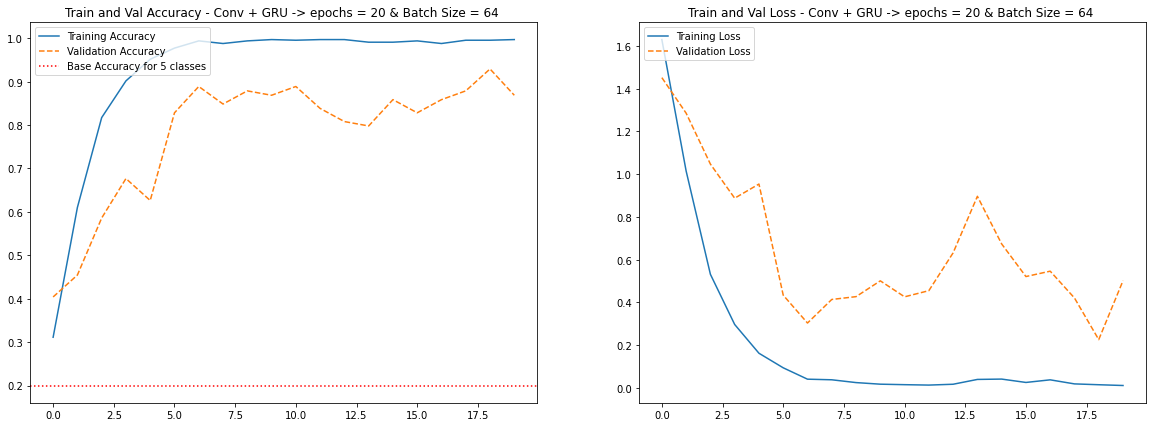

In [116]:
GetModelPerformances(history = Model3.history,
                     epochs = num_epochs, 
                     info = "Conv + GRU -> epochs = 20 & Batch Size = 64 ") 

**Conclusion for Model - 3**

  ○ Model accuracy has improved to almost 95% and validation accuracy to 90%.

  ○ Thus, MobileNet is best suited for this application.

  ○ The best model is found to be at the *epoch # 19(File -> model-00019-0.01442-0.99547-0.22564-0.92929.h5)* which we will use for inference with test and unseen data.







# 3D-Convulation 

## Model build experiment - 4

In [117]:
def Generate3DModel_1():

  Conv_3D = Sequential() # 20 FPS 


  Conv_3D.add(Conv3D(16,kernel_size = 3, strides = 1 , input_shape = (20,90,90,3),  padding='same', activation='relu'  ))
  Conv_3D.add(BatchNormalization())



  Conv_3D.add(Conv3D(32,kernel_size = 3, strides = 1 ,  padding='same', activation='relu' ))
  Conv_3D.add(BatchNormalization())
  Conv_3D.add(MaxPooling3D((3,3,3)))



  Conv_3D.add(Conv3D(64,kernel_size = 3, strides = 1 ,  padding='same', activation='relu' ))
  Conv_3D.add(BatchNormalization())
  Conv_3D.add(MaxPooling3D((2,2,2)))
  Conv_3D.add(Dropout(0.4))
  

  Conv_3D.add(Flatten())


  Conv_3D.add(Dense(256, activation = 'relu'))

  Conv_3D.add(Dropout(0.4))

  Conv_3D.add(Dense(5, activation = 'softmax'))

  return Conv_3D

In [126]:
Model4 = CompileModel(Generate3DModel_1(), 'Adam')
Model4.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 20, 90, 90, 16)    1312      
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 90, 90, 16)    64        
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 20, 90, 90, 32)    13856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 90, 90, 32)    128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 6, 30, 30, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 6, 30, 30, 64)     55360     
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 30, 30, 64)   

In [127]:
ES = EarlyStopping(monitor='val_loss', 
                  min_delta=0.001, 
                  patience=5, 
                  verbose=1,
                  mode='auto')

ModelPath, FilePath = GenerateModelPath(directory)

CSVLogPath = ModelPath + 'TrainLog.csv'

CSVLog = CSVLogger(filename = CSVLogPath, 
                   separator=",", 
                   append=False)

In [128]:
callback_list = [ES, CSVLog, LR]

In [129]:
batch_size =  32
num_epochs = 20

In [130]:
train_generator = generator(train_path, train_doc, batch_size, True, [ -15, -10, -5, 5, 10, 15])
val_generator = generator(val_path, val_doc, batch_size, False)

In [131]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [132]:
# with 20 epochs + batch size = 32
Model4.fit(train_generator, steps_per_epoch=steps_per_epoch, 
              epochs=num_epochs, verbose=1, 
              callbacks=callbacks_list, validation_data=val_generator,  
              validation_steps=validation_steps, class_weight=None, 
              workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Deep Learning/RNN/Assignments/Project_data/Project_data/train ; batch size =  32
Epoch 1/20
21/21 [==============================] - 114s 6s/step - loss: 11.5857 - categorical_accuracy: 0.3807 - val_loss: 13.1325 - val_categorical_accuracy: 0.2626

Epoch 00001: val_loss did not improve from 0.22564
Epoch 2/20
21/21 [==============================] - 113s 6s/step - loss: 2.4351 - categorical_accuracy: 0.5347 - val_loss: 3.2821 - val_categorical_accuracy: 0.2929

Epoch 00002: val_loss did not improve from 0.22564
Epoch 3/20
21/21 [==============================] - 112s 6s/step - loss: 1.4028 - categorical_accuracy: 0.5544 - val_loss: 4.5475 - val_categorical_accuracy: 0.2222

Epoch 00003: val_loss did not improve from 0.22564
Epoch 4/20
21/21 [==============================] - 111s 6s/step - loss: 1.1278 - categorical_accuracy: 0.5861 - val_loss: 9.6093 - val_categorical_accuracy: 0.2222

Epoch 00004: val_loss did not improve from 0.22564
Epoch 5/20


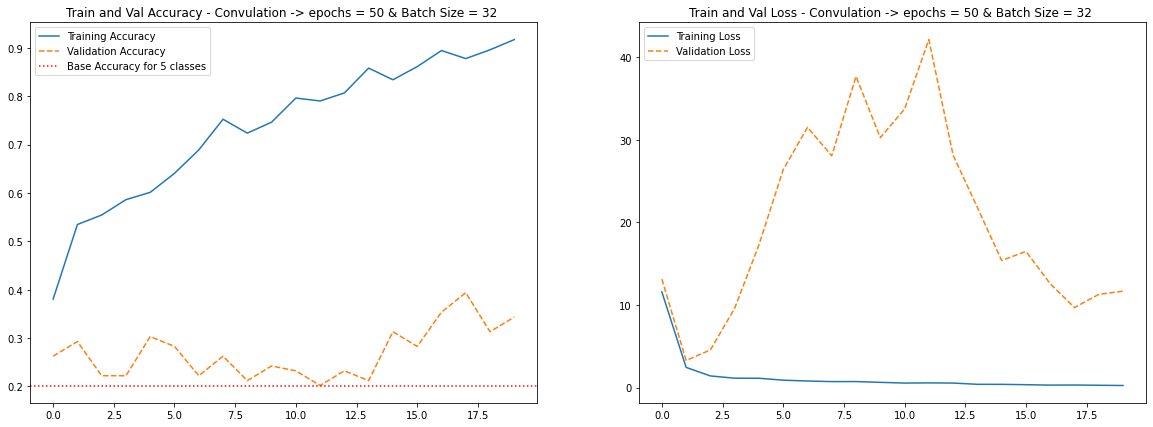

In [133]:
GetModelPerformances(history = Model4 .history,
                     epochs = num_epochs, 
                     info = "3D Convulation -> epochs = 20 & Batch Size = 32 ")

**Conclusion for Model - 4**

  ○ Model is overfitting pretty badly.

  ○ Adding more layers with dropouts might help to exrtract important features.

  ○ Need to add more regularization to reduce model complexity.

  ○ Try with more augmentation angles.

 







## Model build experiment - 5

In [134]:
def Generate3DModel_2():

  Conv_3D = Sequential() # 20 FPS


  Conv_3D.add(Conv3D(16,kernel_size = 3, strides = 1 , input_shape = (20,90,90,3),  padding='same', activation='relu'  ))
  Conv_3D.add(BatchNormalization())
  Conv_3D.add(MaxPooling3D((2,2,2)))



  Conv_3D.add(Conv3D(32,kernel_size = 3, strides = 1 ,  padding='same', activation='relu' ))
  Conv_3D.add(BatchNormalization())
  Conv_3D.add(MaxPooling3D((2,2,2)))



  Conv_3D.add(Conv3D(64,kernel_size = 2, strides = 1 ,  padding='same', activation='relu' ))
  Conv_3D.add(BatchNormalization())
  Conv_3D.add(MaxPooling3D((2,2,2)))


  Conv_3D.add(Conv3D(128,kernel_size = 2, strides = 1 ,  padding='same', activation='relu' ))
  Conv_3D.add(BatchNormalization())
  Conv_3D.add(MaxPooling3D((2,2,2)))
  Conv_3D.add(Dropout(0.3))
  

  Conv_3D.add(Flatten())


  Conv_3D.add(Dense(128, activation = 'relu'))

  Conv_3D.add(Dropout(0.3))

  Conv_3D.add(Dense(5, activation = 'softmax'))

  return Conv_3D

In [135]:
Model5 = CompileModel(Generate3DModel_2(), 'Adam')
Model5.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 20, 90, 90, 16)    1312      
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 90, 90, 16)    64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 45, 45, 16)    0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 10, 45, 45, 32)    13856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 10, 45, 45, 32)    128       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 5, 22, 22, 32)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 5, 22, 22, 64)   

In [136]:
ModelPath, FilePath = GenerateModelPath(directory)

CSVLogPath = ModelPath + 'TrainLog.csv'

CSVLog = CSVLogger(filename = CSVLogPath, 
                   separator=",", 
                   append=False)

In [137]:
callback_list = [CSVLog, LR]

In [138]:
train_generator = generator(train_path, train_doc, batch_size, True, [ -15, -10, -5, 5, 10, 15])
val_generator = generator(val_path, val_doc, batch_size, False)

In [139]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [140]:
# with 20 epochs + batch size = 32
Model5.fit(train_generator, steps_per_epoch=steps_per_epoch, 
              epochs=num_epochs, verbose=1, 
              callbacks=callbacks_list, validation_data=val_generator,  
              validation_steps=validation_steps, class_weight=None, 
              workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Deep Learning/RNN/Assignments/Project_data/Project_data/train ; batch size =  32
Epoch 1/20
21/21 [==============================] - 115s 6s/step - loss: 3.0093 - categorical_accuracy: 0.3308 - val_loss: 1.5395 - val_categorical_accuracy: 0.3030

Epoch 00001: val_loss did not improve from 0.22564
Epoch 2/20
21/21 [==============================] - 114s 6s/step - loss: 1.1790 - categorical_accuracy: 0.4970 - val_loss: 2.6242 - val_categorical_accuracy: 0.1616

Epoch 00002: val_loss did not improve from 0.22564
Epoch 3/20
21/21 [==============================] - 114s 6s/step - loss: 1.0568 - categorical_accuracy: 0.5997 - val_loss: 5.5877 - val_categorical_accuracy: 0.1616

Epoch 00003: val_loss did not improve from 0.22564
Epoch 4/20
21/21 [==============================] - 111s 6s/step - loss: 0.9216 - categorical_accuracy: 0.6480 - val_loss: 6.7594 - val_categorical_accuracy: 0.1818

Epoch 00004: val_loss did not improve from 0.22564
Epoch 5/20
21

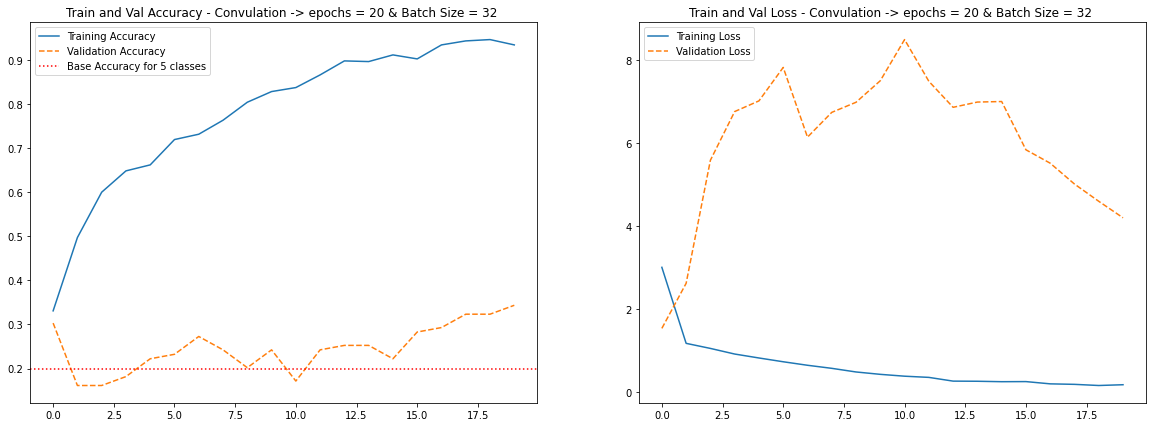

In [141]:
GetModelPerformances(history = Model5.history,
                     epochs = num_epochs, 
                     info = "Convulation -> epochs = 20 & Batch Size = 32 ")

**Conclusion for Model - 5**

  ○ Model is overfitting pretty badly.

  ○ Having more data might be able to solve the issues.







# Final Model


*As we can see that MobileNet + GRU model performed best among all others and thus that's our chosen final model.* 

In [145]:
FileName = 'model-00019-0.01442-0.99547-0.22564-0.92929.h5'
inference_model  = load_model(directory +'/'+FileName )

**TEST FOLDER & DOC PATH**

*While evaluating, test folder path and doc path need to be given*

In [146]:
#just for test purposes we're using the validation folder path
test_path = val_path 

#just for test purposes we're using the validation folder path
test_doc = np.random.permutation(open(directory + '/Project_data/Project_data/val.csv').readlines()) 

batch_size = 32

In [147]:
test_generator = generator(test_path, test_doc, batch_size, False)
batch_data, batch_labels = next(test_generator)
print(batch_labels)

Source path =  /content/drive/MyDrive/Deep Learning/RNN/Assignments/Project_data/Project_data/val ; batch size =  32
[[0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]]


In [148]:
labels = ['Thumbs up', 'Thumbs down', 'Left swipe', 'Right swipe', 'Stop']

In [154]:
label_indexes = np.argmax(inference_model.predict(batch_data[:,:,:,:,:]),axis=1)

for data in ["Predicted gesture is -> {}".format(labels[i]) for i in label_indexes]:
  print( data)


Predicted gesture is -> Right swipe
Predicted gesture is -> Thumbs down
Predicted gesture is -> Thumbs down
Predicted gesture is -> Right swipe
Predicted gesture is -> Thumbs down
Predicted gesture is -> Left swipe
Predicted gesture is -> Thumbs down
Predicted gesture is -> Right swipe
Predicted gesture is -> Left swipe
Predicted gesture is -> Thumbs down
Predicted gesture is -> Right swipe
Predicted gesture is -> Right swipe
Predicted gesture is -> Left swipe
Predicted gesture is -> Thumbs down
Predicted gesture is -> Thumbs down
Predicted gesture is -> Right swipe
Predicted gesture is -> Left swipe
Predicted gesture is -> Stop
Predicted gesture is -> Thumbs up
Predicted gesture is -> Thumbs down
Predicted gesture is -> Left swipe
Predicted gesture is -> Right swipe
Predicted gesture is -> Thumbs up
Predicted gesture is -> Left swipe
Predicted gesture is -> Thumbs up
Predicted gesture is -> Thumbs down
Predicted gesture is -> Thumbs down
Predicted gesture is -> Thumbs down
Predicted g